In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d

from skimage import data, io, color
from skimage.transform import resize

plt.rcParams['figure.figsize'] = [8, 8]

def show_plot(image):
    plt.imshow(image, cmap=plt.get_cmap("gray"))
    plt.colorbar()
    plt.show()

##### Decimation matrix - assumes only taking 4 neighbours and that $L = M*2$

In [2]:
# l = 8
# m = 4
# d = l // m

# d_matrix = np.zeros((m**2, l**2))

# tile = np.repeat((1, 0, 1), (2, l - 2, 2)) # assuming taking 2 neighbours per dimension
# t_len = tile.shape[0]

# for p in np.arange(l//4):
#     p_offset = p * l # 8
#     for q in np.arange(m):
#         d_matrix[q+ p_offset//2, q*d + p_offset*2 : q*d+t_len + p_offset*2] = tile # top-left quadrant
#         r_offset = m**2 // 2
#         c_offset = l**2 // 2
#         d_matrix[q+r_offset + p_offset//2, q*d+c_offset + p_offset*2: q*d+t_len+c_offset + p_offset*2] = tile # bottom-right quadrant

In [3]:
# x = np.arange(1, 65) # 1..64
# print(x.reshape(8, 8))

# y = np.matmul(d_matrix * 1/4, x)
# print(y.reshape(4, 4))

##### Sharpening matrix - Laplacian operator

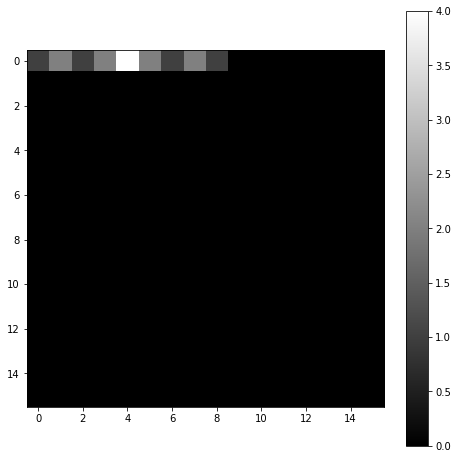

In [149]:
# x_true = color.rgb2gray(data.astronaut())
# x = resize(x_true, (100, 100), anti_aliasing=True)
# show_plot(x)

# laplace_deblur = np.array([[0, -1,  0], [-1,  4, -1], [0, -1,  0]], dtype=np.float32)
# show_plot(convolve2d(x, laplace_deblur, mode="same") )

# l = x.shape[0]
l = 4
s_matrix = np.zeros((l**2, l**2))
laplacian = np.array([[1.0, 2.0, 1.0], [2.0, 4.0, 2.0], [1.0, 2.0, 1.0]])

for s_r in np.arange(1):
    for k_r in np.arange(laplacian.shape[0]):
        
        
show_plot(s_matrix)
        
# laplacian = np.array([0.0, -1.0, 0.0, -1.0, 4.0, -1.0, 0.0, -1.0, 0.0])
# for r in np.arange(l**2):
#     left_trim = np.absolute(min(r-4, 0))
#     right_trim = max(r+5-l**2, 0)
#     s_matrix[r, max(r-4, 0) : min(r+5, l**2)] = laplacian[left_trim:9-right_trim]
        
# convolved = np.matmul(s_matrix, x.flatten())
# show_plot(convolved.reshape(100, 100))